In [1]:
%matplotlib inline
import sys
sys.path.append('../../')
from modules.tools import open_file, dataframe, ohlc_chart, norm, set_ATR, product_info, rolling_window
from modules.tdop import area_ratio

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter, argrelextrema
from IPython.display import clear_output
import time

In [9]:
symbol = 'GC'

pinfo = product_info()

pdens = open_file('h5py', f'etc/GC_TDOP_2year.h5', mode='r')
ohlc_raw = open_file('h5py', 'raw data/daily_futures.h5', mode='r')

tdop_db = pdens[symbol]
ohlc = dataframe(f'CME_{symbol}', ohlc_raw)

set_ATR(ohlc, span=20)
dates = tdop_db['dates'].value.astype('M8[s]')
tdops = tdop_db['tdop'].value
price = tdop_db['prices'].value

In [8]:
def split(arr, idx):
    groups = np.split(arr, np.where(np.diff(arr) != 1)[0]+1)
    args = []
    for group in groups:
        args.append(np.abs(group - idx).min())
    sortedargs = np.argsort(args)
    
    return np.array(groups)[sortedargs]


In [11]:
def show_graph(date):
    window = 30#int(ohlc.loc[date].ATR/pinfo['LC']['tick_unit'] ) * 1
    idx = np.where(dates==np.datetime64(date))[0][0]
    tdop = tdops[idx]
    tdop = savgol_filter(tdop, window*2+1, 3)
    tdop = norm(tdops[idx], ntype='minmax')
    
    #area_diff = area_ratio(tdop, window=window)
    #area_diff = np.where(tdop>0.2, area_diff, 0)
    area_diff = np.where(tdop>0.8, tdop, 0)
    
    fig=plt.figure(figsize=(15,9))
    ax=fig.add_subplot(111, label="ohlc")
    ax2=fig.add_subplot(111, label="tdop", frame_on=False)

    ax.yaxis.tick_right()
    start = date-np.timedelta64(360,'D')
    end = date+np.timedelta64(3,'D')
    #ax.set_xlim([date-np.timedelta64(720,'D'),date+np.timedelta64(3,'D')])
    ax = ohlc_chart(ax, ohlc.loc[start:end])
    #ax.plot(ohlc.close.loc[start:end], color='black')
    #ax.axvspan(end-np.timedelta64(40,'D'), end, color='yellow', alpha=0.5)
    
    #ax.set_ylim([1100, 2000])
    #ax.set_xlim(['2010-05-01',date+np.timedelta64(3,'D')])
    #ax2.plot(area_diff, price, color="red", alpha=1, linewidth=0.8)
    ax2.fill_betweenx(price, 0,np.where(area_diff>0.7, 1, 0), color="red", alpha=0.4)
    ax2.fill_betweenx(price, 0,np.where(area_diff<-0.7, 1, 0), color="blue", alpha=0.4)
    #ax2.plot(np.where(area_diff<-0.5, 1, 0), price, color="blue", alpha=1, linewidth=0.8)
    ax2.set_ylim(ax.get_ylim())
    ax2.xaxis.tick_top()
    ax2.set_xlim([0, 1])
    
    plt.show()

In [13]:
from scipy.stats import gaussian_kde

In [24]:
from sklearn.mixture import GaussianMixture

In [41]:
clf = GaussianMixture(n_components=10, covariance_type='full')
clf.fit(tdops[-1].reshape(-1,1))

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=10, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

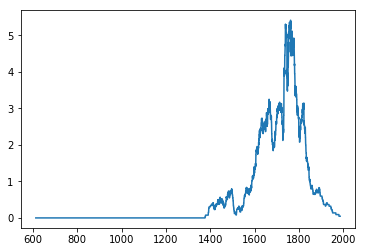

In [11]:
plt.plot(price,tdops[idx])

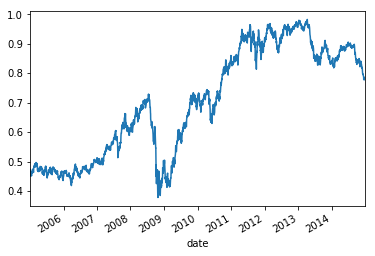

In [9]:
ohlc.close.plot()

In [60]:
y=[]
for i in range(10):
    y1 = np.random.normal(clf.means_[i][0], np.squeeze(clf.covariances_)[i], size=1000)
    y.append(y1)

In [62]:
s = np.array(y[0])    

In [70]:
data = np.array(tdops[-1]).reshape(-1,1)
clf = GaussianMixture(n_components=10, covariance_type='full')
clf.fit(data)

x = np.arange(0,14000).reshape(-1,1)
y = clf.samples(x)

plt.plot(x, y)
plt.show()

AttributeError: 'GaussianMixture' object has no attribute 'samples'

In [80]:
s=clf.sample(3000)

In [83]:
mean = np.mean(data, axis=0)

In [84]:
mean

array([ 754.58085783])

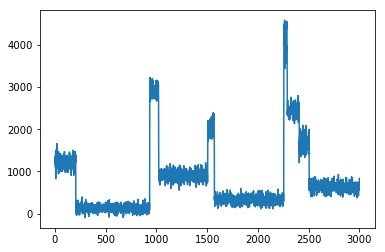

In [82]:
plt.plot(np.squeeze(s[0]))

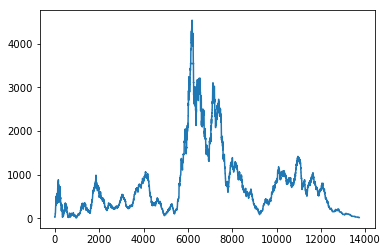

In [79]:
plt.plot(tdops[-1])

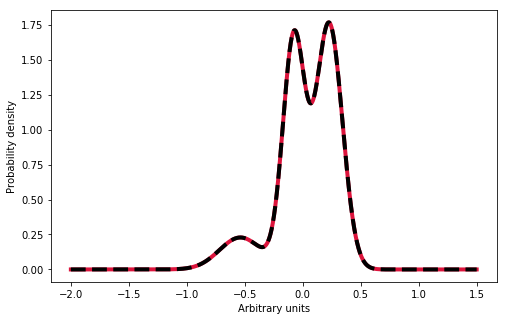

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# Define simple gaussian
def gauss_function(x, amp, x0, sigma):
    return amp * np.exp(-(x - x0) ** 2. / (2. * sigma ** 2.))

# Generate sample from three gaussian distributions
samples = np.random.normal(-0.5, 0.2, 2000)
samples = np.append(samples, np.random.normal(-0.1, 0.07, 5000))
samples = np.append(samples, np.random.normal(0.2, 0.13, 10000))
#samples = tdops[-1]
# Fit GMM
gmm = GaussianMixture(n_components=3, covariance_type="full", tol=0.001)
gmm = gmm.fit(X=np.expand_dims(samples, 1))

# Evaluate GMM
gmm_x = np.linspace(-2, 1.5, 5000)
gmm_y = np.exp(gmm.score_samples(gmm_x.reshape(-1, 1)))

# Construct function manually as sum of gaussians
gmm_y_sum = np.full_like(gmm_x, fill_value=0, dtype=np.float32)
for m, c, w in zip(gmm.means_.ravel(), gmm.covariances_.ravel(), gmm.weights_.ravel()):
    gauss = gauss_function(x=gmm_x, amp=1, x0=m, sigma=np.sqrt(c))
    gmm_y_sum += gauss / np.trapz(gauss, gmm_x) * w

# Make regular histogram
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[8, 5])
ax.plot(gmm_x, gmm_y, color="crimson", lw=4, label="GMM")
ax.plot(gmm_x, gmm_y_sum, color="black", lw=4, label="Gauss_sum", linestyle="dashed")

# Annotate diagram
ax.set_ylabel("Probability density")
ax.set_xlabel("Arbitrary units")

In [93]:
gmm = GaussianMixture(n_components=3, covariance_type="full", tol=0.001)
gmm = gmm.fit(X=np.expand_dims(tdops[-1], 1))

In [94]:
gmm.means_

array([[  762.31062181],
       [ 2257.08374556],
       [  213.81741073]])

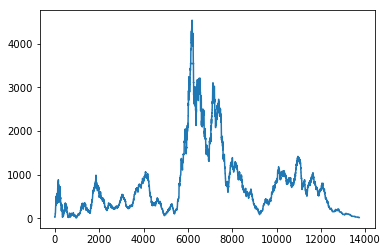

In [92]:
plt.plot(tdops[-1])

In [8]:
dates[1]

numpy.datetime64('3026800-11-25')

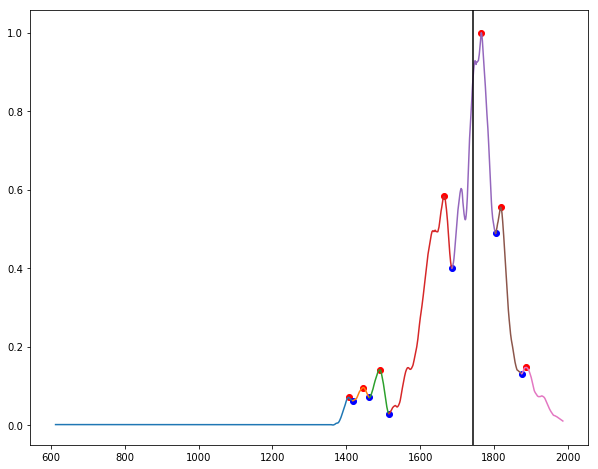

In [10]:
idx = 2002
date = dates[idx]
close = ohlc.loc[date].close
atr=int(ohlc.loc[date].ATR/pinfo['GC']['tick_unit'])
window = 100

tdop = tdops[idx]
tdop = savgol_filter(tdop, atr*2+1, 2)
tdop = norm(tdop, ntype='minmax')
#tdop_grad = np.gradient(tdop)
    
argtops = argrelextrema(tdop, np.greater, order=atr)[0]
argbots= np.array([x + tdop[x:y].argmin() for x,y in  zip(argtops[:-1], argtops[1:])])
splited = np.split(range(len(tdop)), argbots)

fig=plt.figure(figsize=(10,8))
ax=fig.add_subplot(111, label="tdop")
#ax2=fig.add_subplot(111, label="tdop_grad", frame_on=False)

#ax.plot(price, tdop, color='grey')
for arr in splited:
    ax.plot(price[arr],tdop[arr])
ax.scatter(price[argtops], tdop[argtops], color='red')
ax.scatter(price[argbots], tdop[argbots], color='blue')
ax.axvline(close, color='black')

plt.show()
#    time.sleep(1)
#    clear_output(wait=True)

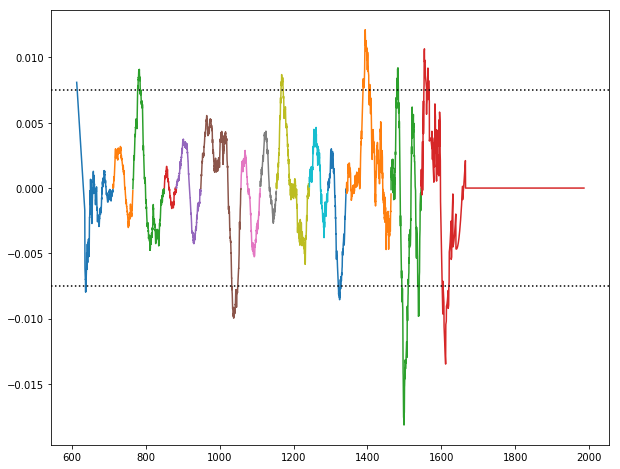

In [240]:
tdop_grad = np.gradient(tdop)

fig=plt.figure(figsize=(10,8))
ax=fig.add_subplot(111, label="tdop")

for arr in argsplit:
    ax.plot(price[arr], tdop_grad[arr])
ax.axhline(tdop_grad.std()*2, color='black', linestyle=':')
ax.axhline(-tdop_grad.std()*2, color='black', linestyle=':')


In [ ]:
mins = []
maxs = []
for date in ohlc.index[::1]:
    print(f'\r {date} ',flush=True, end='')
    close = ohlc.loc[date].close
    atr = int(ohlc.loc[date].ATR/pinfo[symbol]['tick_unit'] )
    #window = atr*5
    idx = np.argmax(dates==np.datetime64(date))
    pidx = np.abs(price-ohlc.loc[date].close).argmin()
    
    tdop = tdops[idx]
    tdop = savgol_filter(tdop, atr*2+1, 2)
    tdop = norm(tdop, ntype='zscore')
    #tdop_grad = np.gradient(tdop)
    
    #argtops = argrelextrema(tdop, np.greater, order=atr)[0]
    #argtops = argtops[tdop[argtops]>1]
    #bots = [x + tdop[x:y].argmin() for x,y in  zip(argtops[:-1], argtops[1:])]
    #argbots = []
    #        argbots.append(bot)
    #argbots = np.array(argbots)
    
    #argbots = argbots[tdop[argbots]<1]
    #argsplit = np.split(range(len(tdop)), argbots)
    
    argtops = argrelextrema(tdop, np.greater, order=atr)[0]
    bots = [x + tdop[x:y].argmin() for x,y in  zip(argtops[:-1], argtops[1:])]
    while(True):
        argsplit = np.split(range(len(tdop)), bots)
        for arr in argsplit:
            m = tdop[arr].max()
            left = tdop[arr[0]]
            right = tdop[arr[-1]]
            if  min(m-left, m-right) < 0.51:
                bot = arr[0] if left > right else arr[-1]+1
                if bot not in bots:
                    bot = arr[-1]+1 if bot == arr[0] else arr[0]
                bots.remove(bot)
                flag = True
                break
            else:
                flag = False
        if not flag:
            break
    argsplit[-1] =np.arange(argsplit[-1][0],argsplit[-1][0]+tdop[argsplit[-1]].argmin() )
    #"""
    for arg in argsplit:
        if pidx in arg:
            mins.append(price[arg[0]])
            maxs.append(price[arg[-1]])
    #"""
    """
    argbots = np.array(bots)
    
    #lastarg = tdop[argsplit[-1]].argmin()
    #argsplit[-1] = list(range(argsplit[-1][0], lastarg))
    
    fig=plt.figure(figsize=(10,8))
    ax=fig.add_subplot(111, label="tdop")
    
    for arg in argsplit:
        ax.plot(price[arg],tdop[arg])
    #ax.scatter(price[argtops], tdop[argtops], color='red')
    ax.scatter(price[argbots], tdop[argbots], color='blue')
    ax.axvline(close, color='black')
    ax.set_ylim([-2, 5])
    plt.show()
    time.sleep(0.3)
    clear_output(wait=True)
    """

 2010-07-30 00:00:00 

In [363]:
argsplit[-1] =np.arange(argsplit[-1][0],argsplit[-1][0]+tdop[argsplit[-1]].argmin() )

In [19]:
maxs = []
lmaxs = []
argmins = []
argmaxs = []
for date in ohlc.index[:]:
    print(f"\r {date}   ", flush=True, end='')
    atr = int(ohlc.loc[date].ATR/pinfo['GC']['tick_unit'] )
    window = atr*5
    close = ohlc.loc[date].close
    pidx = np.abs(price-close).argmin()
    idx = np.argmax(dates==np.datetime64(date))
    
    tdop = tdops[idx]
    #tdop = savgol_filter(tdop, 301, 3)
    tdop = savgol_filter(tdop, int(window/2)*2+ 1, 3)
    tdop = norm(tdop, ntype='minmax')
    ratio = area_ratio(tdop, window=atr)
    
    
    localtdop = np.zeros(len(tdop))
    start = pidx - window if pidx - window>0 else 0
    #end = pidx+200 if pidx + 200 < len(tdop) else len(tdop)-1
    localtdop[start:pidx+window] = tdop[start:pidx+window]
    
    args = argrelextrema(tdop, np.greater, order=atr)[0]
    args = args[(start <= args) | ( (args <= pidx+window))]
    
    if (len(args) == 0):
        toparg = localtdop.argmax()
    
    elif np.count_nonzero(localtdop[args]) == 0:
        toparg = np.abs(price-lmaxs[-1]).argmin()#localtdop.argmax()
    else:
        #toparg = args[localtdop[args].argmax()]
        toparg = args[np.abs(args - pidx).argmin()]
    
    #toparg = np.nanargmax(localtdop)
    lmaxs.append(price[toparg])
    
    ratiomaxs = argrelextrema(ratio, np.greater_equal, order=20)[0]
    ratiomins = argrelextrema(ratio, np.less_equal, order=20)[0]
    
    extrema = np.append(ratiomaxs, ratiomins)
    extrema = extrema[np.abs(extrema - toparg).argsort()]
    
    arg1 = extrema[0]
    for arg in extrema[1:]:
        if ratio[arg] * ratio[arg1] > 0:
            continue
        elif (toparg - arg) * (toparg - arg1) > 0:
            continue
        else:
            arg2 = arg
            break
            
    argmins.append(price[min(arg1, arg2)])
    argmaxs.append(price[max(arg1, arg2)])


 2005-03-29 00:00:00   

KeyboardInterrupt: 

(700, 1200)

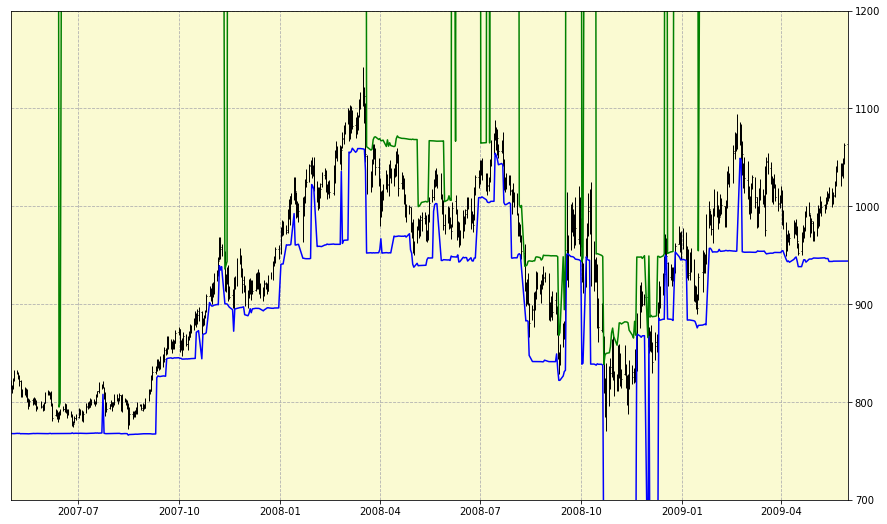

In [357]:
data = ohlc[:]
fig=plt.figure(figsize=(15,9))
ax=fig.add_subplot(111, label="ohlc")
ax = ohlc_chart(ax, data)
#ax.plot(data.index, mins)
#ax.plot(data.index, maxs)
#ax.plot(data.index, lmax_day, color='blue')
#ax.plot(data.index, lmaxs, color='red')
ax.plot(data.index, mins, color='blue')
ax.plot(data.index, maxs, color='green')
ax.set_xlim(['2007-05-01','2009-06-01'])
ax.set_ylim([700, 1200])

In [55]:
maxs = []
lmaxs = []
argmins = []
argmaxs = []
for date in ohlc.index[:]:
    print(f"\r {date}   ", flush=True, end='')
    atr = int(ohlc.loc[date].ATR/pinfo['GC']['tick_unit'] )
    window = atr*5
    close = ohlc.loc[date].close
    pidx = np.abs(price-close).argmin()
    idx = np.argmax(dates==np.datetime64(date))
    
    tdop = tdops[idx]
    #tdop = savgol_filter(tdop, 301, 3)
    tdop = savgol_filter(tdop, int(window/2)*2+ 1, 3)
    tdop = norm(tdop, ntype='minmax')
    
    
    
    args = argrelextrema(tdop, np.greater, order=atr)[0]
    
   # if np.count_nonzero(localtdop[args]) == 0:
   #     toparg = np.abs(price-lmaxs[-1]).argmin()#localtdop.argmax()
   # else:
   #toparg = args[tdop[args].argmax()]
    toparg = args[np.abs(args - pidx).argmin()]
    
    #toparg = np.nanargmax(localtdop)
    lmaxs.append(price[toparg])

 2014-12-31 00:00:00   

(900, 1350)

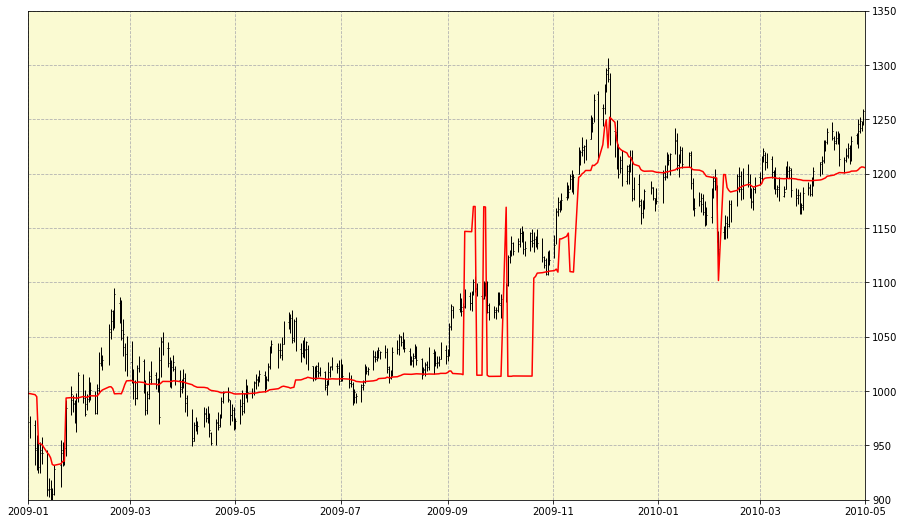

In [58]:
data = ohlc[:]
fig=plt.figure(figsize=(15,9))
ax=fig.add_subplot(111, label="ohlc")
ax = ohlc_chart(ax, data)
ax.plot(data.index, lmaxs, color='red')
ax.set_xlim(['2009-01-01','2010-05-01'])
ax.set_ylim([900, 1350])

In [27]:
a = rolling_window(tdop, window=100)

In [30]:
a.sum(axis=-1).shape

(13635,)

In [31]:
tdop.shape

(13734,)

In [32]:
lmaxs_week = lmaxs


In [44]:
d

array([  636.3,   634.3,   633.7, ...,  1770.7,  1769.9,  1766.8])

In [131]:
p = np.argwhere(price == ohlc.loc[date].close)[0][0]

In [138]:
maxidx[np.abs(p-maxidx).argsort()[0]]

7554

In [90]:
np.intersect1d(maxidx, s)

array([ 317,  596,  983, 1725, 2290], dtype=int64)

In [91]:
maxidx

array([ 317,  596,  983, 1530, 1725, 1932, 2290], dtype=int64)

In [61]:
ratio[mask]=0

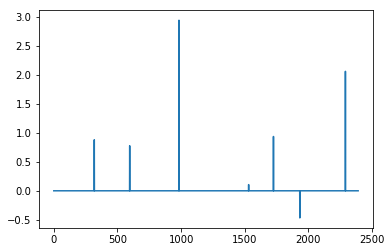

In [62]:
plt.plot(ratio)

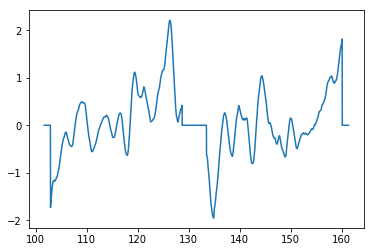

In [21]:
plt.plot(price,area_diff)

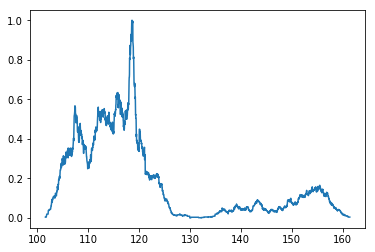

In [20]:
plt.plot(price,tdop)

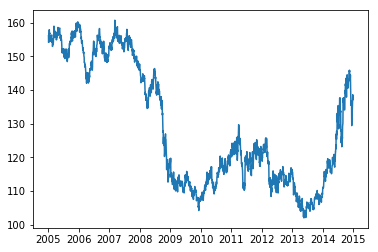

In [302]:
plt.plot(ohlc.close)

In [343]:
window = 50
lmaxs = []

for date in ohlc.index[:200]:
    print(f'\r {date}  ', flush=True, end='')
    
    idx = np.where(dates == np.datetime64(date))[0][0]
    closeprice = ohlc.loc[date].close
    closeidx = np.where(price == closeprice)[0][0]
    
    tdop = tdops[idx]
    smoothed = savgol_filter(tdop, window*2+1, 3)
    
    localmax = argrelmax(smoothed, order=window)[0]
    #localmax = localmax[localmax <= closeidx]
    localmax = localmax[np.abs(localmax - closeidx).argsort()[-5:]]
    
    lmax = price[localmax]
    lmax = np.append(lmax, np.full(7-len(lmax), np.nan))
    
    lmaxs.append(lmax)

lmaxs = np.array(lmaxs)

 2014-12-31 00:00:00  

In [347]:
diff = area_ratio(arr, window=25)

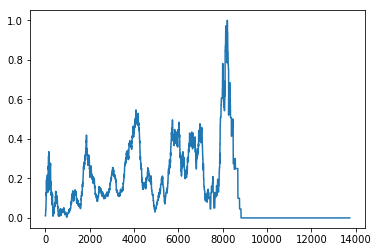

In [463]:
plt.plot(arr)

In [350]:
arr

array([ 0.01008529,  0.01008529,  0.01008529, ...,  0.        ,
        0.        ,  0.        ])

In [351]:
tdop.shape

(13734,)

In [239]:
lmaxs = lmax

In [240]:
test

array([array([ 636.3]), array([ 632.5]), array([ 632.3])], dtype=object)

In [237]:
ohlc.index.shape

(2516,)

In [247]:
np.empty(3)

array([ 1.,  2.,  3.])

In [246]:
np.array([np.nan])+ np.array([1,2,3])

array([ nan,  nan,  nan])

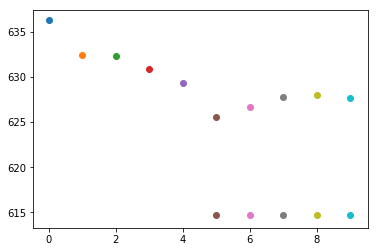

In [232]:
x = np.array( [np.full(5, i) for i in range(10) ] )
for i in range(10):
    plt.scatter(np.full(len(lmax[i]), i),lmax[i])

In [231]:
lmax[0].shape

(1,)

In [224]:
lmax.shape

(10, 5)

In [127]:
closeprice

618.60000000000002

In [131]:
s=np.abs(price[localmax] - closeprice).argsort()

In [137]:
np.where(price == closeprice)[0][0]

57

In [136]:
localmax

(array([ 56, 150], dtype=int64),)

In [359]:
price.shape

(13734,)

In [366]:
diff.shape

(13734,)

In [363]:
diff = area_ratio(arr, window=window)
localmaxs = argrelmax(diff, order=window)[0]

In [365]:
localmaxs

array([ 171,  257,  326,  576,  684,  767,  849,  937, 1071, 1249, 1395,
       1472, 1759, 1887, 1984, 2072, 2241, 2517, 2594, 2796, 3080, 3194,
       3421, 3709, 3843, 3969, 4120, 4270, 4351, 4489, 4666, 4788, 4891,
       5161, 5340, 5465, 5604, 5752, 5922, 6065, 6216, 6354, 6528, 6791,
       7132, 7233], dtype=int64)

(800, 1000)

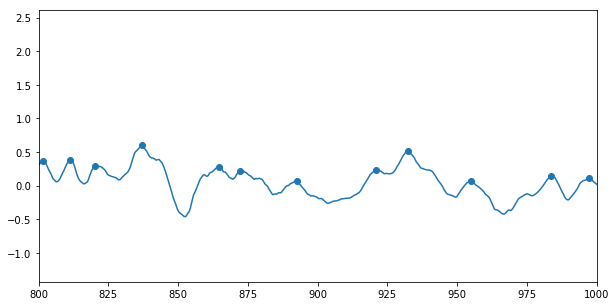

In [369]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(price, diff)
ax.scatter(price[localmaxs], diff[localmaxs])
ax.set_xlim([800,1000])
#plt.scatter(localmax, smoothed[localmax], color='red')


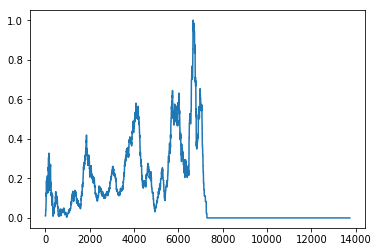

In [21]:
plt.plot(arr)

In [9]:
set_ATR(ohlc)

NameError: name 'pd' is not defined

In [588]:
def autoscale_y(ax,margin=0.1):
    """This function rescales the y-axis based on the data that is visible given the current xlim of the axis.
    ax -- a matplotlib axes object
    margin -- the fraction of the total height of the y-data to pad the upper and lower ylims"""


    def get_bottom_top(line):
        xd = line.get_xdata()
        yd = line.get_ydata()
        lo,hi = ax.get_xlim()
        y_displayed = yd[((xd>lo) & (xd<hi))]
        h = np.max(y_displayed) - np.min(y_displayed)
        bot = np.min(y_displayed)-margin*h
        top = np.max(y_displayed)+margin*h
        return bot,top

    lines = ax.get_lines()
    bot,top = np.inf, -np.inf

    for line in lines:
        new_bot, new_top = get_bottom_top(line)
        if new_bot < bot: bot = new_bot
        if new_top > top: top = new_top

    ax.set_ylim(bot,top)